# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN & Pix2Pix in PyTorch, Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* [A list of generative models](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='assets/gan_pipeline.png' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

If you're interested in generating only new images, you can throw out the discriminator after training. In this notebook, I'll show you how to define and train these adversarial networks in PyTorch and generate new images!

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize the data

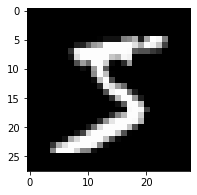

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='assets/gan_network.png' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='assets/leaky_relu.png' width=40% />

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** and binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers
        # notice the input image is flattened 28x28 = 784
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        # output is of dimension 1 because it is 0 = fake, 1 = real , unlike mnist 10 digit classfier than had an output of 10
        self.fc4 = nn.Linear(hidden_dim, output_size)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # flatten image
        # double check the shape of x
        x = x.view(-1, input_size)
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        fc1_pre_activation = self.fc1(x)
        fc1_post_activation = self.leaky_relu(fc1_pre_activation)
        fc1_dropout = self.dropout(fc1_post_activation)
        
        fc2_pre_activation = self.fc2(fc1_dropout)
        fc2_post_activation = self.leaky_relu(fc2_pre_activation)
        fc2_dropout = self.dropout(fc2_post_activation)
        
        fc3_pre_activation = self.fc3(fc2_dropout)
        fc3_post_activation = self.leaky_relu(fc3_pre_activation)
        fc3_dropout = self.dropout(fc3_post_activation)
        
        fc4_pre_activation = self.fc4(fc3_dropout)
        # fc4_post_activation = self.leaky_relu(fc4_pre_activation)
        # fc4_dropout = self.dropout(fc4_post_activation)
        # x = F.log_softmax(self.fc4(x), dim=1)
        x = fc4_pre_activation
        return x


## Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/nn.html#tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1. 

<img src='assets/tanh_fn.png' width=40% />

Recall that we also want these outputs to be comparable to the *real* input pixel values, which are read in as normalized values between 0 and 1. 
> So, we'll also have to **scale our real input images to have pixel values between -1 and 1** when we train the discriminator. 

I'll do this in the training loop, later on.

In [8]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define all layers
        # input is a random image of size : dim * dim = input_size. 
        #  input is getting larger and larger unlike discriminator
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, x):
        # pass x through all layers
        
        # final layer should have tanh applied
        fc1_pre_activation = self.fc1(x)
        fc1_post_activation = self.leaky_relu(fc1_pre_activation)
        fc1_dropout = self.dropout(fc1_post_activation)
        
        fc2_pre_activation = self.fc2(fc1_dropout)
        fc2_post_activation = self.leaky_relu(fc2_pre_activation)
        fc2_dropout = self.dropout(fc2_post_activation)
        
        fc3_pre_activation = self.fc3(fc2_dropout)
        fc3_post_activation = self.leaky_relu(fc3_pre_activation)
        fc3_dropout = self.dropout(fc3_post_activation)
        
        fc4_pre_activation = self.fc4(fc3_dropout)
        # fc4_post_activation = self.leaky_relu(fc4_pre_activation)
        # fc4_dropout = self.dropout(fc4_post_activation)
        # x = F.log_softmax(self.fc4(x), dim=1)

        x = F.tanh(fc4_pre_activation)
        return x

## Model hyperparameters

In [11]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
# the rsults is very sensitive specially if this is large, the generator does very poorly.
# it seems you need to compress the image quite a bit before increasing its size
# or you need to gradually increase its size
g_hidden_size = 32  

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [12]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
D = D.cuda()
G = Generator(z_size, g_hidden_size, g_output_size)
G = G.cuda()
# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.25)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.25)
)


---
## Discriminator and Generator Losses

Now we need to calculate the losses. 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

<img src='assets/gan_pipeline.png' width=70% />

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [13]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    # BCE is the regular cross entropy loss with only two classes 
    # this is more stable than using sigmoid as the final layer and then BCEloss which suffers from numerical instability because 
    # sigmoid(large) = 1, sigmoid(very very larger) = 1, same goes for the negative values in the sigmoid 
    # the BCE applies sigmoid to logits output
    D_out.to(device)
    criterion = nn.BCEWithLogitsLoss().cuda()
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size).to(device)
    if smooth:
        # format is criterion(y_hat or prediction , y_true or label)
        loss = criterion(D_out.squeeze(), labels * 0.9) 
    else:
        loss = criterion(D_out.squeeze(), labels )   # real labels
    return loss


def fake_loss(D_out):
    # compare logits to fake labels
    criterion = nn.BCEWithLogitsLoss().cuda()
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size).to(device)
    loss = criterion(D_out.squeeze(), labels) 
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [14]:
import torch.optim as optim

# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
discriminator_parameters = list(D.parameters())
d_optimizer = torch.optim.Adam(D.parameters(), lr)

generator_parameters = list(G.parameters())
g_optimizer = torch.optim.Adam(generator_parameters, lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [15]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.cuda() 

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.cuda()               
        batch_size = real_images.size(0)
        ## Important rescaling step ## 
        ## we want the real images scale match that of generator output.
        ## generator output passes through tanh which means its values are between [-1, 1]
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)

        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        d_optimizer.zero_grad()
        # 1. Train with real images
        
        # Compute the discriminator losses on real images
        # use smoothed labels
        real_losses = real_loss(D(real_images), smooth=False)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.cuda() 
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        fake_losses = fake_loss(D(fake_images))
        
        # add up real and fake losses and perform backprop
        d_loss = real_losses + fake_losses
        
        # Backward pass.
        d_loss.backward()
        
        # Update the parameters in the optimizer.
        d_optimizer.step()        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z2 = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z2 = torch.from_numpy(z2).float()
        z2 = z2.cuda()
        generator_training_fake_images = G(z2)
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        discriminator_score_fake_images = D(generator_training_fake_images)
        discriminator_loss_fake_labels = real_loss(discriminator_score_fake_images)
        # perform backprop
        g_loss = discriminator_loss_fake_labels
        # Backward pass.
        g_loss.backward()
        
        # Update the parameters in the optimizer.
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3998 | g_loss: 0.7423


/home/pemfir/anaconda3/envs/comp_vis/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.6699 | g_loss: 1.4566
Epoch [    1/  100] | d_loss: 1.1496 | g_loss: 0.9697
Epoch [    2/  100] | d_loss: 1.6176 | g_loss: 0.3501
Epoch [    2/  100] | d_loss: 1.3528 | g_loss: 0.7072
Epoch [    2/  100] | d_loss: 1.3977 | g_loss: 0.9091
Epoch [    3/  100] | d_loss: 1.0537 | g_loss: 1.1170
Epoch [    3/  100] | d_loss: 0.8755 | g_loss: 1.7625
Epoch [    3/  100] | d_loss: 0.7028 | g_loss: 1.7466
Epoch [    4/  100] | d_loss: 1.1681 | g_loss: 1.0176
Epoch [    4/  100] | d_loss: 1.0940 | g_loss: 1.3963
Epoch [    4/  100] | d_loss: 1.2461 | g_loss: 1.5119
Epoch [    5/  100] | d_loss: 1.0197 | g_loss: 1.5967
Epoch [    5/  100] | d_loss: 1.0631 | g_loss: 1.2236
Epoch [    5/  100] | d_loss: 1.0784 | g_loss: 1.5067
Epoch [    6/  100] | d_loss: 1.2168 | g_loss: 0.8397
Epoch [    6/  100] | d_loss: 1.0751 | g_loss: 1.0795
Epoch [    6/  100] | d_loss: 1.1622 | g_loss: 1.4430
Epoch [    7/  100] | d_loss: 0.9259 | g_loss: 1.3109
Epoch [    7/  100] | d_loss

Epoch [   52/  100] | d_loss: 1.4712 | g_loss: 1.1534
Epoch [   52/  100] | d_loss: 1.0331 | g_loss: 1.5609
Epoch [   52/  100] | d_loss: 1.2864 | g_loss: 0.9532
Epoch [   53/  100] | d_loss: 1.3734 | g_loss: 0.8599
Epoch [   53/  100] | d_loss: 1.2807 | g_loss: 1.0626
Epoch [   53/  100] | d_loss: 1.2554 | g_loss: 1.0497
Epoch [   54/  100] | d_loss: 1.2977 | g_loss: 1.4126
Epoch [   54/  100] | d_loss: 1.0804 | g_loss: 0.9402
Epoch [   54/  100] | d_loss: 1.2528 | g_loss: 1.0796
Epoch [   55/  100] | d_loss: 1.4833 | g_loss: 0.9559
Epoch [   55/  100] | d_loss: 1.1987 | g_loss: 0.9681
Epoch [   55/  100] | d_loss: 1.2942 | g_loss: 1.2063
Epoch [   56/  100] | d_loss: 1.1848 | g_loss: 1.0344
Epoch [   56/  100] | d_loss: 1.2574 | g_loss: 0.9190
Epoch [   56/  100] | d_loss: 1.4691 | g_loss: 0.9207
Epoch [   57/  100] | d_loss: 1.1560 | g_loss: 1.2885
Epoch [   57/  100] | d_loss: 1.1379 | g_loss: 0.9654
Epoch [   57/  100] | d_loss: 1.4693 | g_loss: 1.1430
Epoch [   58/  100] | d_loss

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

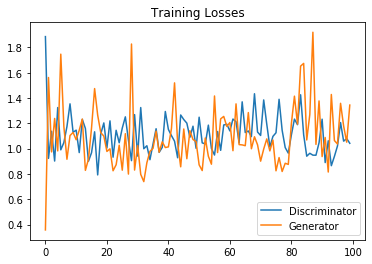

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [17]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)).cpu(), cmap='Greys_r')

In [18]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

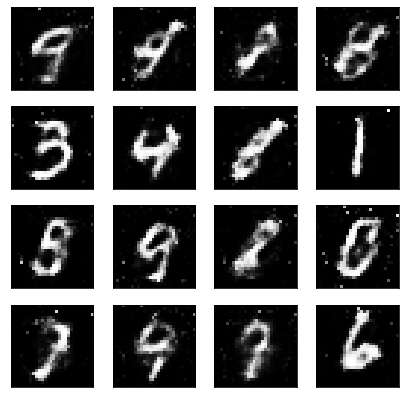

In [19]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

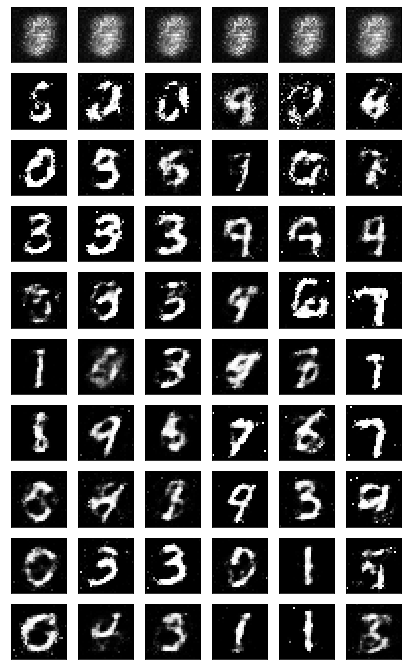

In [20]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach().cpu()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

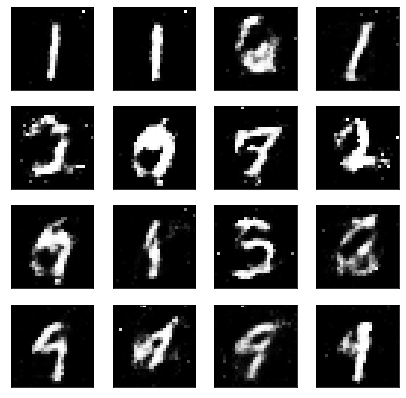

In [21]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()
rand_z = rand_z.cuda()
G.eval() # eval mode
# generated samples
rand_images = G(rand_z)
rand_images = rand_images.cpu()
# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

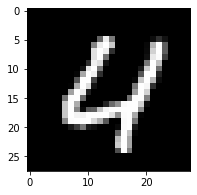

In [53]:
# obtain one batch of training images
# dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

(10, 10)


/home/pemfir/anaconda3/envs/comp_vis/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


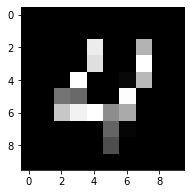

In [54]:
from scipy.ndimage.interpolation import zoom

small_a = zoom(img, 0.35)
print(small_a.shape)
# i_width = 10
# i_height = 10


fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(small_a, cmap='gray')

In [42]:
type(small_a)

numpy.ndarray

In [27]:
img.reshape(10,10)

ValueError: cannot reshape array of size 784 into shape (10,10)

In [26]:
rand_z.shape

torch.Size([1, 100])

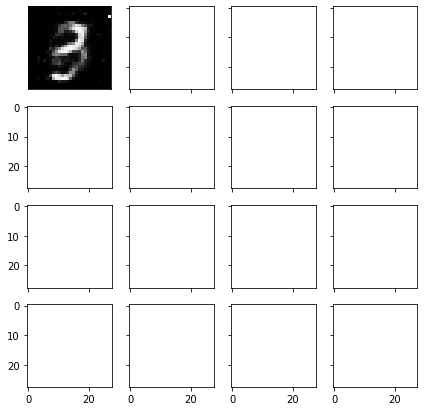

In [55]:
# randomly generated, new latent vectors


sample_size= 1
rand_z = torch.from_numpy(small_a).view(-1, 10*10)
# rand_z = torch.from_numpy(rand_z).float()
rand_z = rand_z.cuda()
G.eval() # eval mode
# generated samples
rand_images = G(rand_z)
rand_images = rand_images.cpu()
# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])